In [98]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [99]:
import sys
sys.path.append('/content/drive/MyDrive/mas/hw5')

# Multi Ageent Reinforcement Learning---- Basic Methods

Methods:
- (1) Joint Q Learning.
- (2) Independent Q Learning.
- (3) Minmax-Q.

Your works:
- (1) Make an overview of the notebook.
- (2) Implmenting the Minmax-Q Method.
- (3) (**Optional, Bonus**) Visualization.

Package requirements:
- (1) numpy.
- (2) matplotlib.
- (3) scipy.
- (4) gym.

## Task
<!-- ![avatar](/content/env/map.png) -->
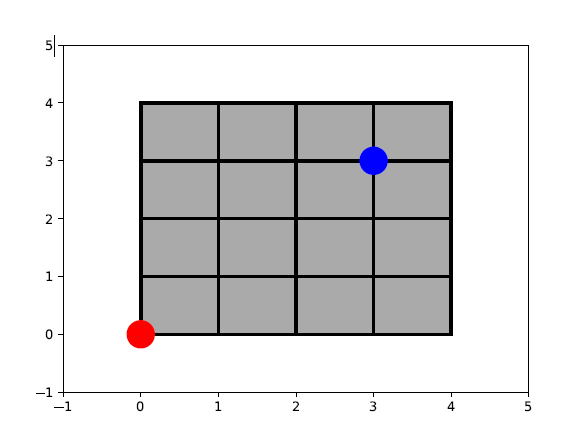

We build a simple mini-grid task, the target is **let the two agent (blue and red) meet each other**. The setting of the tasks is following:
- State: The local state is the coordination of each agent. And the global state is the concatenate coordination of both agents.
- Action: The action space in our environment contains four actions $\{east, south, west, north\}$, each action is the moving direction of the agent.
- Reward: The external reward in our experiment is the Manhattan distance of the two agents.

## Joint Q Learning (Centralized joint policy learning)

The simplest MARL method is directly using single agent methods like Q-learning. 
The only change is using the joint action and joint observation to replace the action and state in single agent setting.
(Generally, other agent's policy will be fixed when executing one agent)

#### Recap: Q-Learning
- Maximize the $Q$ function $Q(s,a)$
- $Q(s,a) \longleftarrow (1-\alpha)Q(s,a) + \alpha(r+\gamma V'(s'))$
- $V'(s') = \max \limits_{a'}Q(s',a')$

In [100]:
import numpy as np
import random
from env import TestEnv
from collections import namedtuple
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

random.seed(20210426)

In [101]:
class JointQLearner(object):
    def __init__(self):
        # q_table (A joint q_table)
        self.q_table = np.zeros((4, 4, 4, 4, 16))
        # learning rate
        self.lr = 0.5
        # discount
        self.gamma = 0.9
        # exploration rate
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        self.env = TestEnv()

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            q_action_value = self.q_table[state[0], state[1], state[2], state[3]]
            action = np.argmax(q_action_value)
        else:
            action = random.randint(0, 15)
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        self.q_table[state[0], state[1], state[2], state[3], action] = \
            (1 - self.lr) * self.q_table[state[0], state[1], state[2], state[3], action] + self.lr * \
            (reward + self.gamma * np.max(self.q_table[next_state[0], next_state[1], next_state[2], next_state[3]]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}". format(epsoide, long_term_reward))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

    def save_q_value_matrix(self):
        np.save("./optimal_q_value.npy", self.q_table)

    def load_q_value_matrix(self):
        self.q_table = np.load("./optimal_q_value.npy")

In [102]:
learner = JointQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -54
Epsoide: 100  Expected Reward: -6
Epsoide: 200  Expected Reward: -6
Epsoide: 300  Expected Reward: -6
Epsoide: 400  Expected Reward: -6
Epsoide: 500  Expected Reward: -6


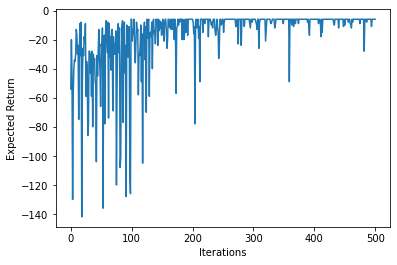

In [103]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)

## Independent Q-learning

In independent Q-learning, each agent $i$ has its own Q function and treats other agents as a part of the environment.


### Procedure of Independent Q Learning
- Each agent $i$ have a individual $Q$ function $Q(s_i,a_i)$;
- For each agent's $Q$ function, it is updated by:

    $Q(s_i,a_i) \longleftarrow (1-\alpha)Q(s_i,a_i) + \alpha(r+\gamma V'({s_i}'))$
- $V'({s_i}') = \max \limits_{{a_i}'}Q({s_i}',{a_i}')$

The main shortage is **non-stationarity** and hard to learn cooperation.

In [104]:
class IndependentQLearner(object):
    def __init__(self):
        # q_table (Each agent has their own q_table)
        self.q_table_alpha = np.zeros((4, 4, 4))
        self.q_table_beta = np.zeros((4, 4, 4))
        # learning rate
        self.lr = 0.5
        # discount
        self.gamma = 0.9
        # exploration rate
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        # build environment
        self.env = TestEnv(joint=False, share_obs=False)

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            q_action_value_alpha = self.q_table_alpha[state[0][0], state[0][1]]
            action_alpha = np.argmax(q_action_value_alpha)
        else:
            action_alpha = random.randint(0, 3)
        if rand > eps_threshold:
            q_action_value_beta = self.q_table_beta[state[1][0], state[1][1]]
            action_beta = np.argmax(q_action_value_beta)
        else:
            action_beta = random.randint(0, 3)
        action = action_alpha * 4 + action_beta
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        act_a, act_b = divmod(action, 4)
        self.q_table_alpha[state[0][0], state[0][1], act_a] = \
            (1 - self.lr) * self.q_table_alpha[state[0][0], state[0][1], act_a] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_alpha[next_state[0][0], next_state[0][1]]))

        self.q_table_beta[state[1][0], state[1][1], act_b] = \
            (1 - self.lr) * self.q_table_beta[state[1][0], state[1][1], act_b] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_beta[next_state[1][0], next_state[1][1]]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}". format(epsoide, long_term_reward))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

In [105]:
learner = IndependentQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -54
Epsoide: 100  Expected Reward: -16
Epsoide: 200  Expected Reward: -6
Epsoide: 300  Expected Reward: -6
Epsoide: 400  Expected Reward: -6
Epsoide: 500  Expected Reward: -6


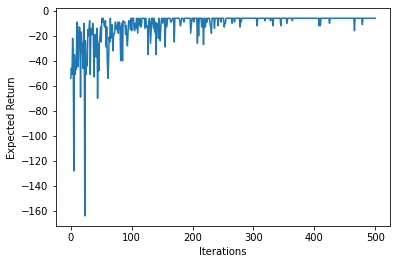

In [106]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)

## Minmax-Q

Like independent Q learning, each agent $i$ has its own Q function

Q-values are over joint actions: $Q(s,a,o)$:
- $s = \text{action}$
- $a = \text{your action}$
- $o = \text{action of the opponent}$
Instead of playing action with highest $Q(s, a, o)$, play **Min-Max**:
$$ Q(s,a,o) = (1-\alpha)Q(s,a,o)+\alpha(r+\gamma V(s'))$$
$$ V(s') = \max\limits_{\pi(s')}\min\limits_{o'}\sum_a Q(s',a',o')$$

Minmax-Q can deal with non-stationarity. It has been proven that the method can reach the $\text{Nash equilibrium}$

In [107]:
class MinmaxQLearner(object):
    def __init__(self):
        # Here you also need to consider about the other agent' action
        self.q_table_alpha = np.zeros((4, 4, 4, 4))
        self.q_table_beta = np.zeros((4, 4, 4, 4))
        self.lr = 0.5
        self.gamma = 0.9
        self.eps_start = 1
        self.eps = self.eps_start
        self.steps_done = 0
        self.env = TestEnv(joint=False, share_obs=False)

    def act(self, state):
        rand = random.random()
        eps_threshold = self.eps
        if rand > eps_threshold:
            alpha_opponent_q_value = \
                [np.mean(self.q_table_alpha[state[0][0], state[0][1], b]) for b in range(4)]
            alpha_opponent_action = np.argmin(alpha_opponent_q_value)
            q_action_value_alpha = self.q_table_alpha[state[0][0], state[0][1], alpha_opponent_action]
            action_alpha = np.argmax(q_action_value_alpha)
        else:
            action_alpha = random.randint(0, 3)
        if rand > eps_threshold:
            beta_opponent_q_value = \
                [np.mean(self.q_table_beta[state[1][0], state[1][1], a]) for a in range(4)]
            beta_opponent_action = np.argmin(beta_opponent_q_value)
            q_action_value_beta = self.q_table_beta[state[1][0], state[1][1], beta_opponent_action]
            action_beta = np.argmax(q_action_value_beta)
        else:
            action_beta = random.randint(0, 3)
        action = action_alpha * 4 + action_beta
        self.steps_done += 1
        return action

    def optimize(self, state, next_state, action, reward):
        act_a, act_b = divmod(action, 4)
        
        alpha_opponent_q_value = \
            [np.mean(self.q_table_alpha[next_state[0][0], next_state[0][1], b]) for b in range(4)]
        beta_opponent_q_value = \
            [np.mean(self.q_table_beta[next_state[1][0], next_state[1][1], a]) for a in range(4)]
        alpha_opponent_action = np.argmin(alpha_opponent_q_value)
        beta_opponent_action = np.argmin(beta_opponent_q_value)
        self.q_table_alpha[state[0][0], state[0][1], act_b, act_a] = \
            (1 - self.lr) * self.q_table_alpha[state[0][0], state[0][1], act_b, act_a] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_alpha[next_state[0][0], next_state[0][1], alpha_opponent_action]))

        self.q_table_beta[state[1][0], state[1][1], act_a, act_b] = \
            (1 - self.lr) * self.q_table_beta[state[1][0], state[1][1], act_a, act_b] + self.lr * \
            (reward + self.gamma * np.max(self.q_table_beta[next_state[1][0], next_state[1][1], beta_opponent_action]))

    def train(self):
        long_term_rewards_list = []
        for epsoide in range(501):
            state = self.env.reset()
            long_term_reward = 0
            step_num = 0
            for i in range(80):
                action = self.act(state)
                next_state, reward, done, _ = self.env.step(action)
                step_num += 1
                long_term_reward += reward
                self.optimize(state, next_state, action, reward)
                state = next_state
                if done:
                    if epsoide % 100 == 0:
                        print("Epsoide: {}  Expected Reward: {}". format(epsoide, long_term_reward))
                    self.eps *= 0.99
                    self.lr *= 0.99
                    long_term_rewards_list.append(long_term_reward)
                    break
        return long_term_rewards_list

In [108]:
learner = MinmaxQLearner()
long_term_rewards = learner.train()

Epsoide: 0  Expected Reward: -42
Epsoide: 100  Expected Reward: -79
Epsoide: 200  Expected Reward: -18
Epsoide: 300  Expected Reward: -8
Epsoide: 400  Expected Reward: -8
Epsoide: 500  Expected Reward: -8


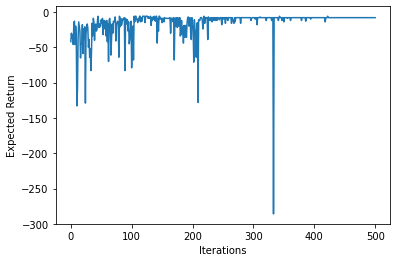

In [109]:
import matplotlib.pyplot as plt
plt.xlabel('Iterations')
plt.ylabel('Expected Return')
iterations = [i for i in range(len(long_term_rewards))]
plt.plot(iterations, long_term_rewards)

# What will happen if we use the max max? (change the argmin to argmax)